Načteme knihovny

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import branca.colormap as cm
import seaborn as sns
import zipfile
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')


Data: https://www.kaggle.com/datasets/dansbecker/melbourne-housing-snapshot

In [4]:
zip_file_path = "./melb_data.csv.zip"
extract_to_directory = "./"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_directory)

Načteme melb_data dataset popisující ceny nemovitostí v Melbourne.

In [5]:
melbourne_file_path = "./melb_data.csv"
melbourne_data = pd.read_csv(melbourne_file_path)
melbourne_data.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,13580.000000,1.358000e+04,13580.000000,13580.000000,13580.000000,13580.000000,13518.000000,13580.000000,7130.000000,8205.000000,13580.000000,13580.000000,13580.000000
mean,2.937997,1.075684e+06,10.137776,3105.301915,2.914728,1.534242,1.610075,558.416127,151.967650,1964.684217,-37.809203,144.995216,7454.417378
std,0.955748,6.393107e+05,5.868725,90.676964,0.965921,0.691712,0.962634,3990.669241,541.014538,37.273762,0.079260,0.103916,4378.581772
min,1.000000,8.500000e+04,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1196.000000,-38.182550,144.431810,249.000000
25%,2.000000,6.500000e+05,6.100000,3044.000000,2.000000,1.000000,1.000000,177.000000,93.000000,1940.000000,-37.856822,144.929600,4380.000000
50%,3.000000,9.030000e+05,9.200000,3084.000000,3.000000,1.000000,2.000000,440.000000,126.000000,1970.000000,-37.802355,145.000100,6555.000000
75%,3.000000,1.330000e+06,13.000000,3148.000000,3.000000,2.000000,2.000000,651.000000,174.000000,1999.000000,-37.756400,145.058305,10331.000000
max,10.000000,9.000000e+06,48.100000,3977.000000,20.000000,8.000000,10.000000,433014.000000,44515.000000,2018.000000,-37.408530,145.526350,21650.000000


Už zde si můžeme například všimnout nesmyslného data 1196 v YearBuilt. - nahradíme hodnotou 1996

Dále si můžeme všimnout že některé domu mají nulový počet ložnicí nebo koupelen.

U některých domů je rovněž zastavěná plocha nulová.

In [6]:
melbourne_data.loc[melbourne_data['YearBuilt'] == 1196, 'YearBuilt'] = 1996

Dále nás může zajímat -
* Predikce výsledné ceny domu
* Shlukování nemovitostí
* Základní statistiky


<Axes: xlabel='YearBuilt', ylabel='Density'>

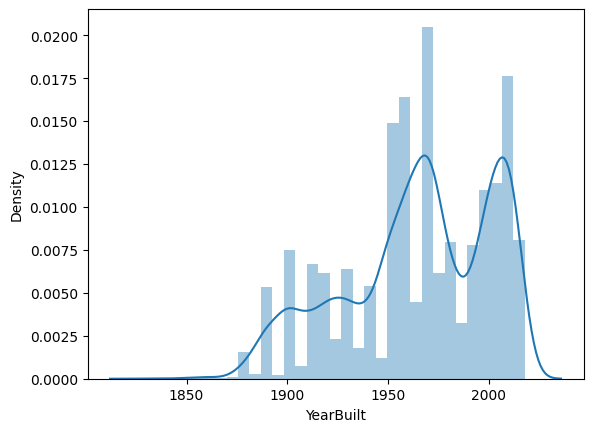

In [7]:
sns.distplot(melbourne_data["YearBuilt"])

<Axes: xlabel='Price', ylabel='Density'>

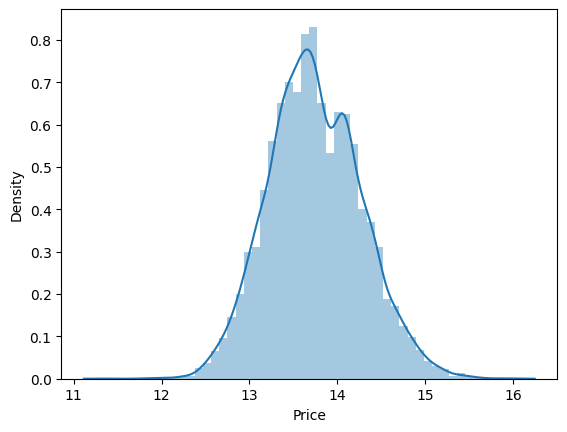

In [8]:
sns.distplot(np.log(melbourne_data["Price"]))
#Dává větší smysl použít logaritmus ceny

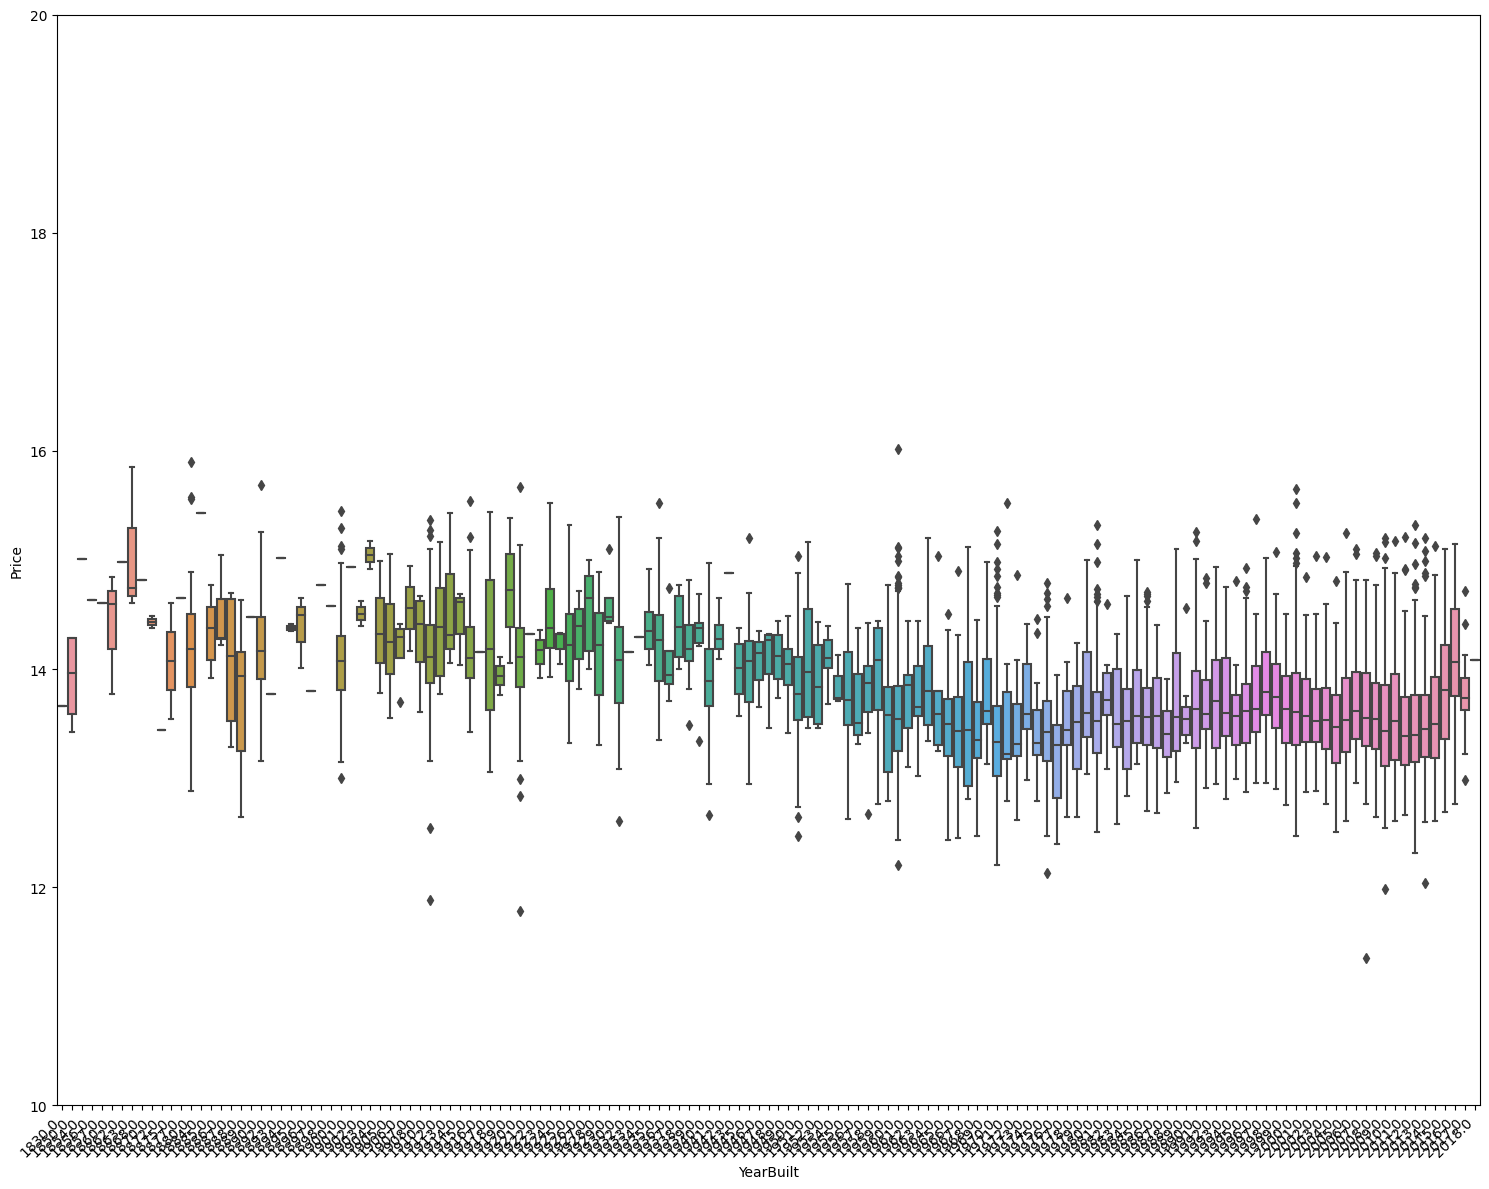

In [9]:
var = 'YearBuilt'
data = pd.concat([np.log(melbourne_data["Price"]), melbourne_data[var]], axis=1)
f, ax = plt.subplots(figsize=(15, 12))
fig = sns.boxplot(x=var, y="Price", data=data)
fig.axis(ymin=10, ymax=20);
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

**Otázka**:
Co nejvíce ovlivňuje cenu domu?

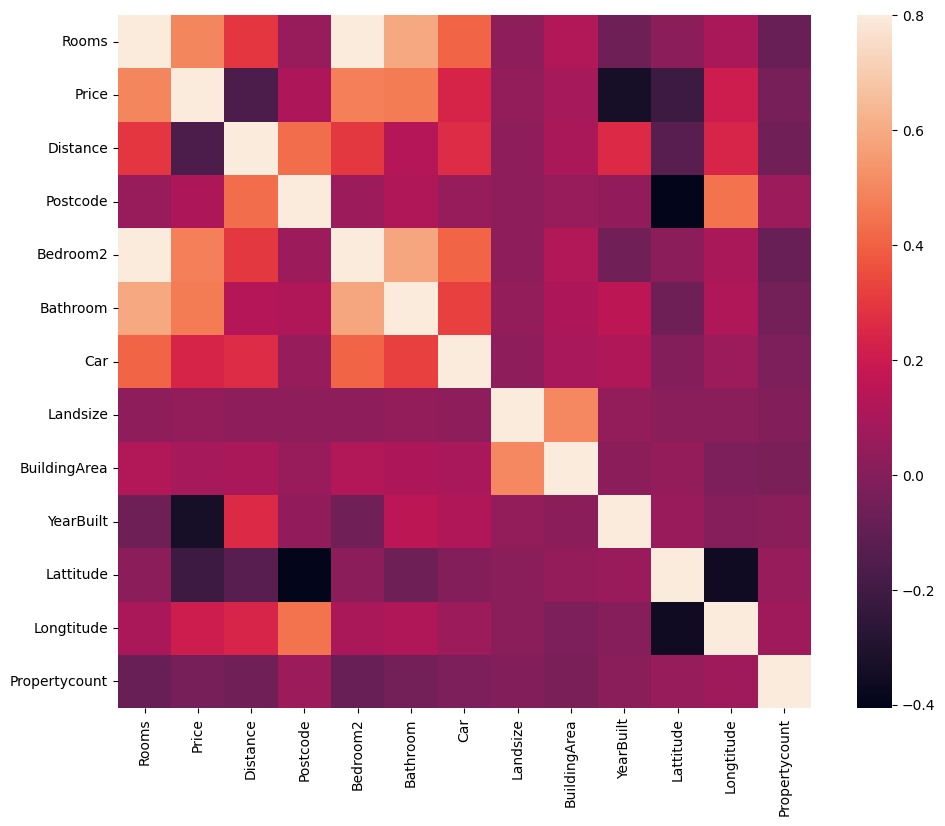

In [10]:
#correlation matrix
corrmat = melbourne_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [14]:
corrmat['Price'].sort_values(ascending=False)

Price            1.000000
Rooms            0.496634
Bedroom2         0.475951
Bathroom         0.467038
Car              0.238979
Longtitude       0.203656
Postcode         0.107867
BuildingArea     0.090981
Landsize         0.037507
Propertycount   -0.042153
Distance        -0.162522
Lattitude       -0.212934
YearBuilt       -0.331791
Name: Price, dtype: float64

Nepřekvapivě máme zápornou lineární korelaci mezi Price a YearBuilt, kterou už máme ověřenou i graficky, tj. starší nemotivosti jsou dražší jak novější.

Největší pozitivní korelaci můžeme pozorovaat mezi Price a Rooms, což také není nic překvapivého (domy s větším počtem místností jsou dražší)

Můžeme si vykreslit jednotlivé domy s jejich cenami na mapě a lze vidět, že klasicky ty dražší domy se nacházejí více v centru a levnější domy se obecně nacházejí dále od centra.

In [15]:
map_center = [melbourne_data['Lattitude'].mean(), melbourne_data['Longtitude'].mean()]
mymap = folium.Map(location=map_center, zoom_start=12)
colormap = cm.linear.YlOrRd_04.scale(min(melbourne_data["Price"]), max(melbourne_data["Price"]))

for index, row in melbourne_data.iterrows():
    folium.CircleMarker(
        location=[row['Lattitude'], row['Longtitude']],
        radius=5,
        color=colormap(row['Price']),
        fill=True,
        fill_color=colormap(row['Price']),
        fill_opacity=0.7,
        popup=f"Price: {row['Price']}"
    ).add_to(mymap)

colormap.caption = 'Price'
colormap.add_to(mymap)

mymap.save('building_map_colored.html')

Případně jiným, ale ekvivalentním způsobem

In [44]:
fig = px.scatter_mapbox(
    melbourne_data,
    lat='Lattitude',
    lon='Longtitude',
    color='Price',
    size='Rooms',
    hover_name='Distance',
    mapbox_style='carto-positron',
    zoom=10
)
fig.update_layout(title='Interactive Map with Prices', mapbox=dict(center=dict(lat=-37.8136, lon=144.9631)))
fig.show()

**Otázka**: Jakého typu nemovitostí je nejvíce? Měnily se preference v průběhu let?

<Axes: xlabel='Type', ylabel='Count'>

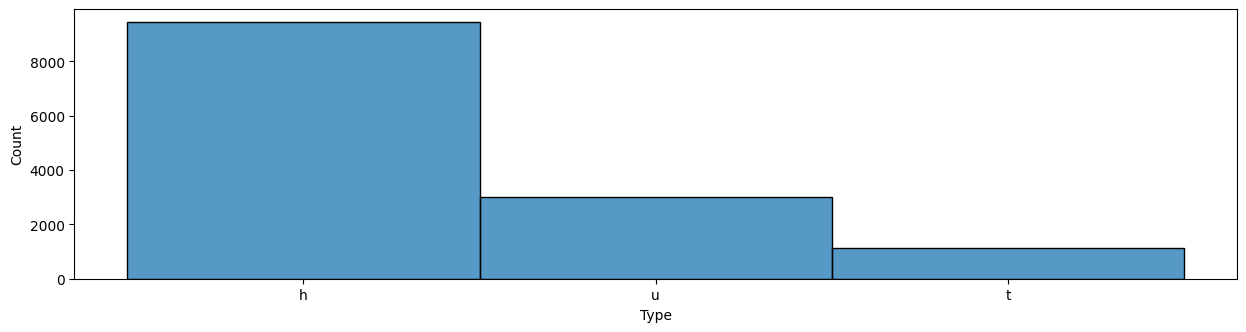

In [39]:
sns.histplot(data=melbourne_data, x='Type')

<Axes: xlabel='Rooms', ylabel='Count'>

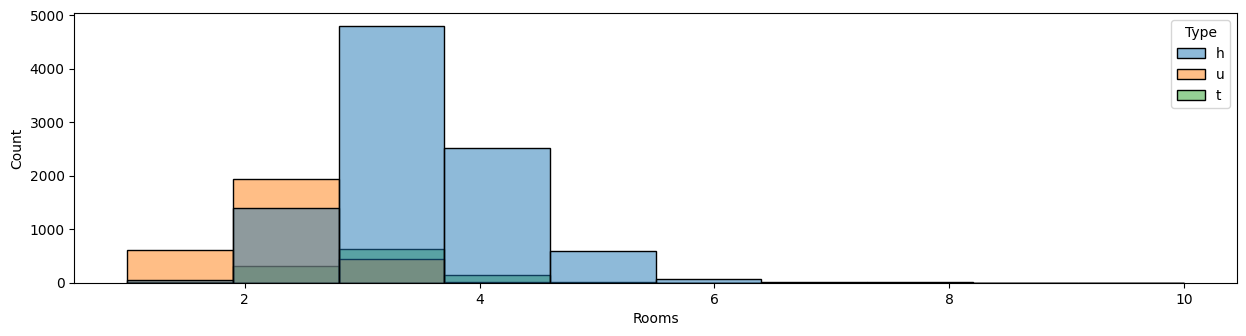

In [40]:
sns.histplot(data=melbourne_data, x='Rooms', bins=10, hue='Type')

In [45]:
fig = px.scatter(melbourne_data, x='YearBuilt', y='Rooms', size='Price', color="Type",
                 title='Vztah mezi cenou (velikost bubliny), počtem místností a rokem výstavby podle typu nemovitosti',
                 labels={'Typ nemovitosti': 'Typ nemovitosti', 'Cena': 'Cena', 'Počet místností': 'Počet místností'},
                 size_max=50, color_continuous_scale='viridis')
fig.show()

<Axes: xlabel='YearBuilt', ylabel='Count'>

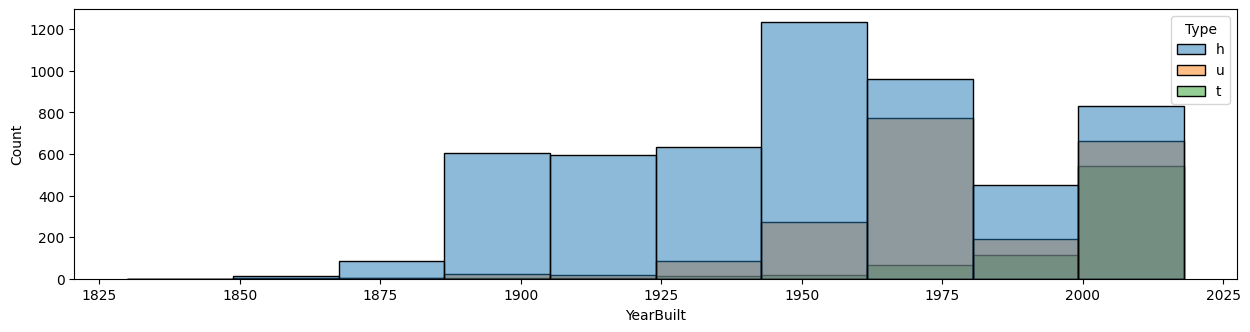

In [42]:
sns.histplot(data=melbourne_data, x='YearBuilt', bins=10, hue='Type')

Vidíme, že nejvíce nemovitostí je typu h, což jsou domy, chaty, vily a poloroubenky. Nejméně je naopak městských domů (t).

Dále si můžeme všimnout, že nejvíce jsou zastoupeny nemovitosti typu h se třemi místnostmi.

V neposlední řadě je patrné, že výstavba městských domů a nemovitostí typu u (jednotky, dvojdomky) se v průběhu let zvyšovala, což ale neovlivnilo množství rodinných domů, které je stále největší.